In [222]:
import pandas as pd
import numpy as np
import seaborn as sns
import copy
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


In [223]:
def mean_squared_error(pred, actual):
    return np.round(np.sum(np.power((pred - actual), 2)) / (2 * len(actual)), 4)

In [377]:
class MLP:
    def __init__(self, layers, learning_rate=0.01, bias=True):
        self.layers = layers
        self.learning_rate = learning_rate
        self.bias = bias
        self.weights = {}
        self.biases = {}
        self.activations = {}
        self.init_weights()
        np.random.seed(42)

    def init_weights(self):
        for i in range(1, len(self.layers)):
            input_units = self.layers[i - 1]['units']
            output_units = self.layers[i]['units']

            self.weights[i] = np.random.rand(input_units, output_units) 

            if self.bias:
                self.biases[i] = np.zeros((1, output_units))

            self.activations[i] = self.layers[i]['activation']
        #print(f"Initialized Weights: {self.weights} \n Activations = {self.activations} \n")

    def forward_propagation(self, x):
        f_net = {0: x} 
        #print(f"Input for layers {0} : {f_net[0]} \n")
        for i in range(1, len(self.layers)):
            z = np.dot(f_net[i - 1], self.weights[i])
            if self.bias:
                z += self.biases[i].flatten().T

            if callable(self.activations[i]):
                f_net[i] = self.activations[i](z)
            else:
                raise ValueError("Activation function must be a callable function")
            #print(f"Results for layer {i} : {f_net[i]} \n")
        return f_net

    def backward_propagation(self, x, y, f_net):
        m = x.shape[0] 
        #print (f_net)
        grads = {}
        for i in reversed(range(1, len(self.layers))):
            if i == len(self.layers) - 1:
                # Output layer
                grads[i] =  y - f_net[i] 
                #print(f"Grads at output {grads[i]}")
                if callable(self.activations[i]):
                    grads[i] *= self.activations[i](f_net[i], derivative=True)
                else:
                    raise ValueError("Activation function must be a callable function")
                
            else:
                # Hidden layers
                grads[i] = np.dot(grads[i + 1], self.weights[i + 1].T)
                if callable(self.activations[i]):
                    grads[i] *= self.activations[i](f_net[i], derivative=True)
                else:
                    raise ValueError("Activation function must be a callable function")
        return grads
    def update_weights(self,grads,f_net):
        # Update weights and biases
        #print(np.dot(f_net[i].T, grads[i].T).shape , grads[i]*f_net[i], self.weights[i],self.weights[i]-(f_net[i]*grads[i]))
        #print(f_net[i-1].shape , grads[i].shape)
        #print(f"Grads : {grads}\n f_net:{f_net} \n")
        for i in range(1,len(self.layers)):
         #   print(f"Result of delta W : {np.outer(f_net[i-1] , grads[i])} \n")
            self.weights[i] += self.learning_rate * np.outer(f_net[i-1] , grads[i])
            if self.bias:
                self.biases[i] += self.learning_rate  * np.sum(grads[i], axis=0, keepdims=True)
        #print(f"After Updates : {self.weights} \n")

    def fit(self, x_train, y_train, epochs=100,get_train_acc=False):
        if type(x_train) == pd.DataFrame:
            x_train = x_train.to_numpy()
        if type(y_train) == pd.DataFrame:
            y_train = y_train.to_numpy()
        for _ in range(epochs):
            for row,target in zip(x_train,y_train):
                f_net = self.forward_propagation(row)
                grads=self.backward_propagation(row, target, f_net)
                self.update_weights(grads,f_net)
            if _ % 10 == 0:
                mse=mean_squared_error(f_net[len(self.layers)-1],y_train)
                print(f"MSE For Epoch {_}: {round(mse,3)} \n")
       
    def predict(self, x_test):
        f_net = self.forward_propagation(x_test)
        output_layer = len(self.layers) - 1
        return f_net[output_layer]
    
    def get_acc(self,x,y):
        pred=self.predict(x)
        predictions_df = pd.DataFrame(pred, columns=sorted(list(y.unique())))
        predicted_labels = predictions_df.idxmax(axis=1)
        accuracy=sum(predicted_labels == y.reset_index(drop=True))
        print(f"Train Accuracy = {round(accuracy,3) / len(x)}")
        accuracy/=len(x)
        return accuracy



In [381]:
from sklearn.metrics import confusion_matrix as conf
def confusion_matrix(y_pred, y_true):
    labels = y_true.unique()
    print (labels) 
    num_labels = len(labels)
    cm = conf(y_true, y_pred, labels=labels)

    plt.figure(figsize=(6, 4))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.colorbar()
    plt.title('Confusion Matrix')
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels)
    plt.yticks(tick_marks, labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

    for i in range(num_labels):
        for j in range(num_labels):
            plt.text(j, i, str(cm[i, j]), ha="center", va="center")


    plt.show()
    return cm

In [226]:
def linear(x):
    return x

def sig_num(a):
    if a == 0:
        return -1
    return int(a / abs(a))

def softmax(x):
        exp_x = np.exp(x - np.max(x, axis=-1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=-1, keepdims=True)


def sigmoid(Z,derivative=False):
    sigmoid_value = 1 / (1 + np.exp(-Z))
    if derivative : 
        return Z * (1 - Z)
    else:
        return sigmoid_value

def tanh(Z, derivative=False):
    tanh_value = np.tanh(Z)
    if derivative : 
        return (1 - Z**2)
    else:
        return tanh_value



In [227]:
def remove_nulls(target,data:pd.DataFrame):
    for cat,df in data.groupby(target):
        for col in df.columns[0:-1]:
            df[col].fillna(df[col].mean(),inplace=True)
            data[data[target]==cat]=df
    return data

In [228]:
def split(target_col,df=pd.DataFrame()):        
    X = df.drop(columns=[target_col])
    Y = df[target_col]
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=3)
    
    return X_train, Y_train, X_test, Y_test

In [229]:
def normalize_dataframe(df):
    normalized_df = pd.DataFrame()
    
    for col in df.columns[:-1]:
        min_val = df[col].min()
        max_val = df[col].max()
        normalized_col = (df[col] - min_val) / (max_val - min_val)
        normalized_df[col] = normalized_col
        
    normalized_df[df.columns[-1]] = df[df.columns[-1]]
    
    return normalized_df


In [230]:
def one_hot_encode_target(target_series):
    one_hot_encoded = pd.get_dummies(target_series, prefix='label')

    return one_hot_encoded

In [231]:
def label_encode_target(target_series):
    dummy_series=copy.deepcopy(target_series)
    for label,i in zip(dummy_series.unique(),range(0,len(dummy_series.unique()))) :
        dummy_series[dummy_series==label]=i
    return dummy_series.astype(float)

In [232]:
def generate_layers(num_layers, num_neurons,activation, train_df ):
    layers = {i: {"units": num_neurons, "activation": activation}
                    for i in range(1,num_layers)}
    layers[0]={"units": train_df.shape[1] , "activation" : linear}
    layers[num_layers]={"units" : 3 , "activation" : activation}
    return layers


In [233]:
beans_df=pd.read_excel("Dry_Bean_Dataset.xlsx")

In [346]:
beans_df=remove_nulls("Class",beans_df)
beans_df=normalize_dataframe(beans_df)
x_train,y_train,x_test,y_test=split("Class",df=beans_df)
layers=generate_layers(10,3,sigmoid,x_train)

In [347]:
y_train_encoded=one_hot_encode_target(y_train)
y_test_encoded=one_hot_encode_target(y_test)

In [348]:
mlp=MLP(bias=True,learning_rate=0.1,layers=layers)
mlp.fit(x_train=x_train,y_train=y_train_encoded,epochs=100)
predictions=mlp.predict(x_test=x_test)

MSE For Epoch 0: 0.336 

MSE For Epoch 10: 0.333 

MSE For Epoch 20: 0.333 

MSE For Epoch 30: 0.333 

MSE For Epoch 40: 0.333 

MSE For Epoch 50: 0.333 

MSE For Epoch 60: 0.333 

MSE For Epoch 70: 0.333 

MSE For Epoch 80: 0.333 

MSE For Epoch 90: 0.333 



In [349]:
predictions_df = pd.DataFrame(predictions, columns=sorted(list(y_test.unique())))
predicted_labels = predictions_df.idxmax(axis=1)

['BOMBAY' 'SIRA' 'CALI']


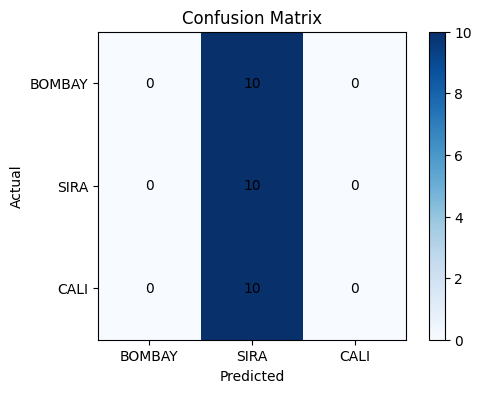

In [350]:
confusion_matrix(y_pred=predicted_labels,y_true=y_test)

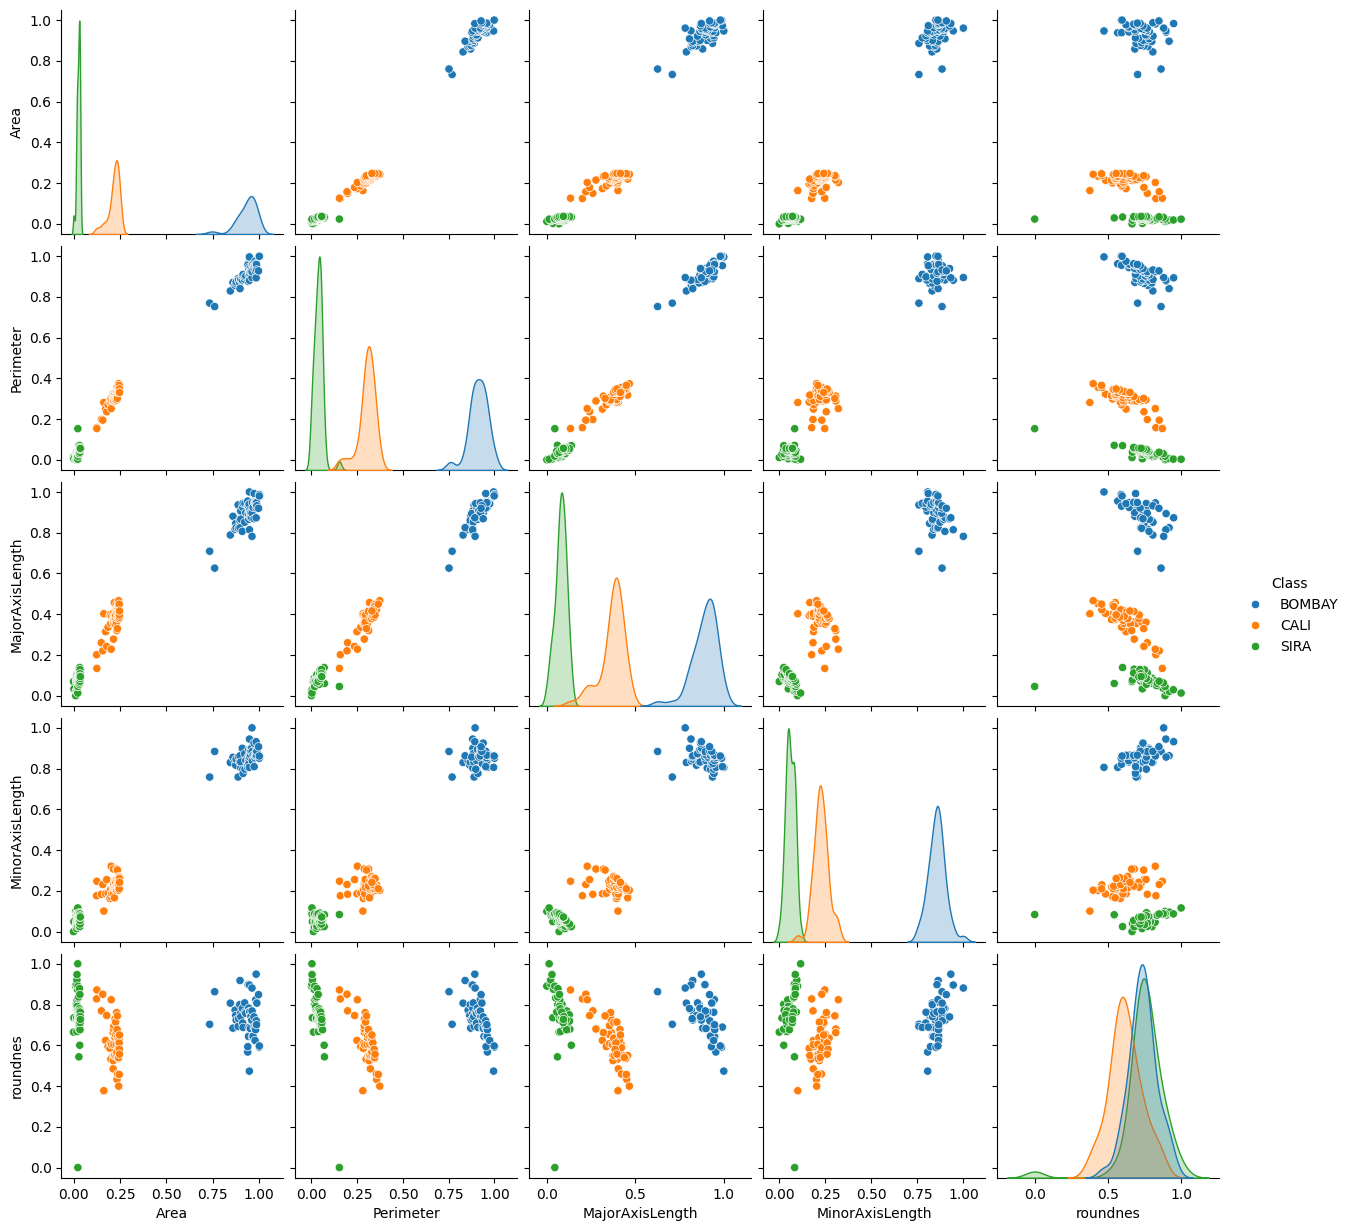

In [352]:
sns.pairplot(data=beans_df, hue="Class")

['BOMBAY' 'SIRA' 'CALI']


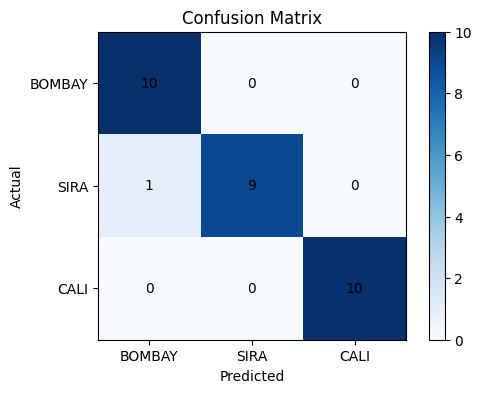

In [382]:
import tkinter as tk
from tkinter import messagebox

def train_network(hidden_layers,neurons_in_layers,learning_rate,epochs,use_bias,activation_function):
    layers=generate_layers(train_df=x_train
                    ,num_layers=hidden_layers + 1 , num_neurons= neurons_in_layers ,activation=globals()[activation_function.lower()])
    mlp=MLP(bias=use_bias,layers=layers,learning_rate= learning_rate)
    mlp.fit(x_train=x_train,y_train=y_train_encoded,epochs=epochs)
    acc=mlp.get_acc(x=x_train,y=y_train) 
    return mlp,acc

def test_sample(model:MLP,y_test,x_test):
    predictions=model.predict(x_test=x_test)
    predictions_df = pd.DataFrame(predictions, columns=sorted(list(y_test.unique())))
    predicted_labels = predictions_df.idxmax(axis=1)
    cm=confusion_matrix(y_pred=predicted_labels,y_true=y_test)
    accuracy=cm.trace() / len(y_test)
    messagebox.showinfo(f"Testing Completed", "Neural Network Testing Completed Successfully! \n Test Accuracy = {}".format(round(accuracy,3)))

    pass

def create_nn_gui():
    root = tk.Tk()
    root.title("Neural Network Configuration")
    model=None
    # Function to get user inputs and start training
    def start_training():
        # Get user inputs from the entry widgets
        params={}
        params["hidden_layers"] = int(hidden_layers_entry.get())
        params["neurons_in_layers"] = int(neuron_entry.get())
        params["learning_rate"] = float(learning_rate_entry.get())
        params["epochs"] = int(epochs_entry.get())
        params["use_bias"] = use_bias_var.get()
        params["activation_function"] = activation_var.get()
        print(params)
        # Perform training based on user inputs
        global model
        model,train_acc=train_network(**params)  # Implement this function

        # Display a message box indicating training completion
        messagebox.showinfo(f"Training Complete", "Neural Network Training Completed Successfully! \n Train Accuracy = {}".format(train_acc))

    # Function to classify a sample
    def test():
        global model
        if model == None : 
            raise AttributeError("Cannot Test Before Training")
        test_sample(model=model,y_test=y_test,x_test=x_test)  # Implement this function

    # Create labels and entry widgets for user input
    labels = ['Number of hidden layers:', 'Neurons in each hidden layer:', 'Learning rate (eta):',
              'Number of epochs (m):', 'Add bias:', 'Activation function:']

    for i, label_text in enumerate(labels):
        label = tk.Label(root, text=label_text)
        label.grid(row=i, column=0, padx=10, pady=5)
        if label_text=='Number of hidden layers:':
            hidden_layers_entry=tk.Entry(root)
            hidden_layers_entry.grid(row=i, column=1, padx=10, pady=5)
            hidden_layers_entry.insert(0,"1")
        elif label_text == 'Neurons in each hidden layer:':
            neuron_entry = tk.Entry(root)
            neuron_entry.grid(row=i, column=1, padx=10, pady=5)
            neuron_entry.insert(0,"3")
        elif label_text == 'Learning rate (eta):':
            learning_rate_entry=tk.Entry(root)
            learning_rate_entry.grid(row=i, column=1, padx=10, pady=5)
            learning_rate_entry.insert(0,"0.1")
        elif label_text == "Number of epochs (m):":
            epochs_entry=tk.Entry(root)
            epochs_entry.grid(row=i, column=1, padx=10, pady=5)
            epochs_entry.insert(0,100)
        elif label_text == 'Add bias:':
            use_bias_var = tk.BooleanVar()
            use_bias_check = tk.Checkbutton(root, variable=use_bias_var)
            use_bias_check.grid(row=i, column=1, padx=10, pady=5)
        elif label_text == 'Activation function:':
            activation_var = tk.StringVar()
            activation_var.set("Sigmoid")  # Default selection
            activation_options = ["Sigmoid", "Tanh"]
            activation_menu = tk.OptionMenu(root, activation_var, *activation_options)
            activation_menu.grid(row=i, column=1, padx=10, pady=5)
        else:
            entry = tk.Entry(root)
            entry.grid(row=i, column=1, padx=10, pady=5)

    # Add buttons for training and classification
    train_button = tk.Button(root, text="Start Training", command=start_training)
    train_button.grid(row=len(labels) + 1, column=0, columnspan=2, padx=10, pady=10)

    classify_button = tk.Button(root, text="Test", command=test)
    classify_button.grid(row=len(labels) + 2, column=0, columnspan=2, padx=10, pady=10)

    root.mainloop()

# Create the GUI
create_nn_gui()